# **Cardiovascular events prediction with clinical data**

## Purpose
The objective of this project is to develop machine learning models capable of predicting cardiovascular events using clinical data from patients. 

## Data Description

- `pid:` Patient indentifier
- `event:` Whether or not a patient has had a cardiovascular event (0 control | 1 event)
- `rd:` Whether or not a patient is diagnosed with Diabetic Retinopahty disease (0 no rd | 1 rd)
- `gender:` Patient's gender (0 female | 1 male)
- `age:` Patient's age
- `dl:` Dyslipidemia (0 no | 1 yes)
- `obe:` Obesity (0 no | 1 yes)
- `tab:` Smoking (0 no | 1 yes)
- `ecbv:` Cerebrovascular Disease (0 no | 1 yes)
- `aei:` Lower Extremity Arterioopathy (0 no | 1 yes)
- `fa:` Atrial Fibrillation (0 no | 1 yes)
- `ci:` Ischemic Heart Disease (0 no | 1 yes)
- `hta:` Arterial Hypertension (0 no | 1 yes)
- `ic:` Heart Failure (0 no | 1 yes)


## Import libraries

In [1]:
import shap
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# data exploration and preparation  
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction import DictVectorizer 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, mutual_info_score, roc_auc_score, confusion_matrix
from lifelines.utils import concordance_index

sns.set(style="whitegrid")
colors = {0: 'skyblue', 1: 'orange'}

/home/ruben/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [2]:
# Load baseline dataset
df_base = pd.read_csv('../input/vit_features_clinical_baseline.csv')

# Remove ViT features and keep just clinical data
df_base_clinical = df_base[[col for col in df_base.columns if not col.startswith('x')]]

# The dataset contains several images for each patient, but the clinical data is the same. Keep just one row per patient and delete image column which is not relevan in this case.
df_base_clinical = df_base_clinical.drop_duplicates(subset='pid', keep='first')
df_base_clinical = df_base_clinical.drop(columns='id')
df_base_clinical


,pid,event,rd,gender,age,dl,obe,tab,ecbv,aei,fa,ci,hta,ic
0,216772,0,0,0,69,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6,20530,1,0,1,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,471397,1,0,0,76,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
20,234871,0,0,1,70,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
26,27817,1,0,0,72,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,17188,1,0,1,67,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1464,464705,1,0,1,65,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1466,542939,1,0,1,67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1472,509791,1,0,0,61,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data exploration and cleaning

In [3]:
# Check for missing values
df_base_clinical.isnull().sum()

pid        0
event      0
rd         0
gender     0
age        0
dl        68
obe       68
tab       68
ecbv      68
aei       68
fa        68
ci        68
hta       68
ic        68
dtype: int64

As we can see there are 68 columns in which we have no data present for the clinical variables. One approach could be to interpolate the data from the rest or use the mean of the data present. In this case as they are categorical variables it would be too inaccurate to approximate the missing values so it would be best to eliminate the columns with missing values.

In [4]:
control_data = len(df_base_clinical[df_base_clinical['event'] == 0])
event_data = len(df_base_clinical[df_base_clinical['event'] == 1])
print(f"Dataframe class distribution: Patients ({control_data+event_data}), Control ({control_data}), Event({event_data})")


Dataframe class distribution: Patients (248), Control (87), Event(161)


In [5]:
# Remove columns with missinf values
df_complete_clinical = df_base_clinical.dropna()

control_data = len(df_complete_clinical[df_complete_clinical['event'] == 0])
event_data = len(df_complete_clinical[df_complete_clinical['event'] == 1])
print(f"Dataframe class distribution: Patients ({control_data+event_data}), Control ({control_data}), Event({event_data})")

df_complete_clinical.isnull().sum()



Dataframe class distribution: Patients (180), Control (86), Event(94)


pid       0
event     0
rd        0
gender    0
age       0
dl        0
obe       0
tab       0
ecbv      0
aei       0
fa        0
ci        0
hta       0
ic        0
dtype: int64

We have now a dataset without null values. Note that most of the removed samples belongs to 'Event' class which does not barely affect the minority class 'Control'.

In [6]:
# For numerical sake, cast categorical variables to integers
df_complete_cast_clinical = df_complete_clinical.copy()
df_complete_cast_clinical[['dl','obe','tab','ecbv','aei','fa','ci','hta','ic']] = df_complete_cast_clinical[['dl','obe','tab','ecbv','aei','fa','ci','hta','ic']].astype(int)
df_complete_cast_clinical

,pid,event,rd,gender,age,dl,obe,tab,ecbv,aei,fa,ci,hta,ic
0,216772,0,0,0,69,1,0,0,0,0,1,0,1,0
12,471397,1,0,0,76,1,0,0,0,0,1,0,1,0
20,234871,0,0,1,70,0,1,0,0,0,1,0,1,0
26,27817,1,0,0,72,0,0,1,0,0,0,0,1,0
32,529335,1,0,0,79,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,255709,0,0,0,50,0,1,0,0,0,1,0,1,0
1459,17188,1,0,1,67,1,1,0,0,0,0,0,1,1
1464,464705,1,0,1,65,0,0,0,0,0,1,0,1,0
1472,509791,1,0,0,61,1,0,0,0,0,0,0,0,0


In [7]:
# Check data types
df_complete_cast_clinical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0 to 1474
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   pid     180 non-null    int64
 1   event   180 non-null    int64
 2   rd      180 non-null    int64
 3   gender  180 non-null    int64
 4   age     180 non-null    int64
 5   dl      180 non-null    int64
 6   obe     180 non-null    int64
 7   tab     180 non-null    int64
 8   ecbv    180 non-null    int64
 9   aei     180 non-null    int64
 10  fa      180 non-null    int64
 11  ci      180 non-null    int64
 12  hta     180 non-null    int64
 13  ic      180 non-null    int64
dtypes: int64(14)
memory usage: 21.1 KB


In [8]:
# Descriptive dataframe information
df_complete_cast_clinical.describe()

,pid,event,rd,gender,age,dl,obe,tab,ecbv,aei,fa,ci,hta,ic
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.0,180.0,180.000000,180.0,180.000000,180.000000
mean,263271.383333,0.522222,0.111111,0.494444,67.866667,0.672222,0.272222,0.088889,0.0,0.0,0.677778,0.0,0.755556,0.061111
std,165904.915275,0.500899,0.315146,0.501364,10.870698,0.470713,0.446345,0.285377,0.0,0.0,0.468631,0.0,0.430956,0.240202
min,1168.000000,0.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
25%,146168.250000,0.000000,0.000000,0.000000,60.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.000000
50%,206544.000000,1.000000,0.000000,0.000000,69.500000,1.000000,0.000000,0.000000,0.0,0.0,1.000000,0.0,1.000000,0.000000
75%,383826.500000,1.000000,0.000000,1.000000,76.000000,1.000000,1.000000,0.000000,0.0,0.0,1.000000,0.0,1.000000,0.000000
max,617090.000000,1.000000,1.000000,1.000000,89.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,0.0,1.000000,1.000000


Inspecting the dataset, we see that the columns ecbv aei and ci do not contribute significant value since the value is 0 in all of them. We could eliminate these columns.

In [9]:
# Remove non-relevant columns
df_clinical = df_complete_cast_clinical.drop(['ecbv','aei','ci'], axis=1)
df_clinical

,pid,event,rd,gender,age,dl,obe,tab,fa,hta,ic
0,216772,0,0,0,69,1,0,0,1,1,0
12,471397,1,0,0,76,1,0,0,1,1,0
20,234871,0,0,1,70,0,1,0,1,1,0
26,27817,1,0,0,72,0,0,1,0,1,0
32,529335,1,0,0,79,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1453,255709,0,0,0,50,0,1,0,1,1,0
1459,17188,1,0,1,67,1,1,0,0,1,1
1464,464705,1,0,1,65,0,0,0,1,1,0
1472,509791,1,0,0,61,1,0,0,0,0,0


## Variable exploration

### Event distribution

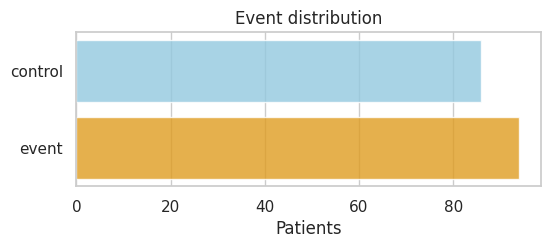

In [10]:
plt.figure(figsize = (6,2))
ax = sns.countplot(y='event', data=df_clinical, palette=colors, alpha=0.8, hue='event', legend=False)
ax.set_xlabel(xlabel = 'Patients')
ax.set_yticks([0,1])
ax.set_yticklabels(['control', 'event'])
ax.set_title(label = 'Event distribution')
plt.ylabel("")
plt.show()

We can se data classes are quite balanced with **86 controls and 94 events**

### Gender and Diabetic Retinopathy

In [11]:
# Gender distribution
gender_dist = df_clinical['gender'].value_counts()
print(f"Gender Distribution:\n{gender_dist}\n ")

# RD distribution
rd_dist = df_clinical['rd'].value_counts()
print(f"RD Distribution:\n{rd_dist}\n ")

Gender Distribution:
gender
0    91
1    89
Name: count, dtype: int64
 
RD Distribution:
rd
0    160
1     20
Name: count, dtype: int64
 


<Figure size 600x400 with 0 Axes>

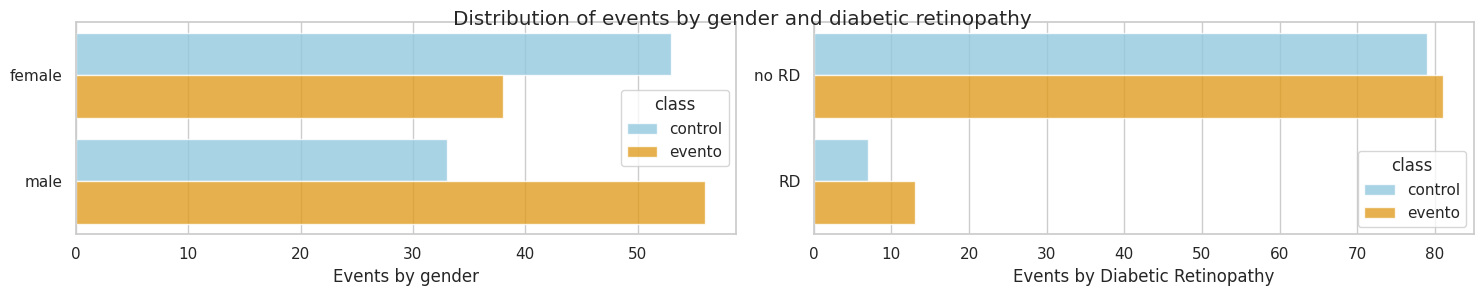

In [12]:
plt.figure(figsize = (6,4))

fig, axs = plt.subplots(1, 2, figsize=(15, 3))

sns.countplot(y='gender', data=df_clinical, palette=colors, alpha=0.8, hue='event', legend=True, ax=axs[0])
axs[0].set_xlabel(xlabel = 'Events by gender')
axs[0].set_yticks([0,1])
axs[0].set_yticklabels(['female', 'male'])
axs[0].set_ylabel("")
axs[0].legend(title='class', labels=['control', 'evento'])

                        
sns.countplot(y='rd', data=df_clinical, palette=colors, alpha=0.8, hue='event', legend=True,ax=axs[1])
axs[1].set_xlabel(xlabel = 'Events by Diabetic Retinopathy')
axs[1].set_yticks([0,1])
axs[1].set_yticklabels(['no RD', 'RD'])
axs[1].set_ylabel("")
axs[1].legend(title='class', labels=['control', 'evento'])


plt.tight_layout()

fig.suptitle(f'Distribution of events by gender and diabetic retinopathy')
plt.show()




As we can see, when we look at gender, we do see imbalances among patients who have had an event. Almost two thirds of men have had a cardiovascular event, while there are more healthy women. On the other hand, the number of patients with diabetic retinopathy is very low and it seems that it will be a variable that will not have much relevance when it comes to predicting cardiovascular events.


### Age

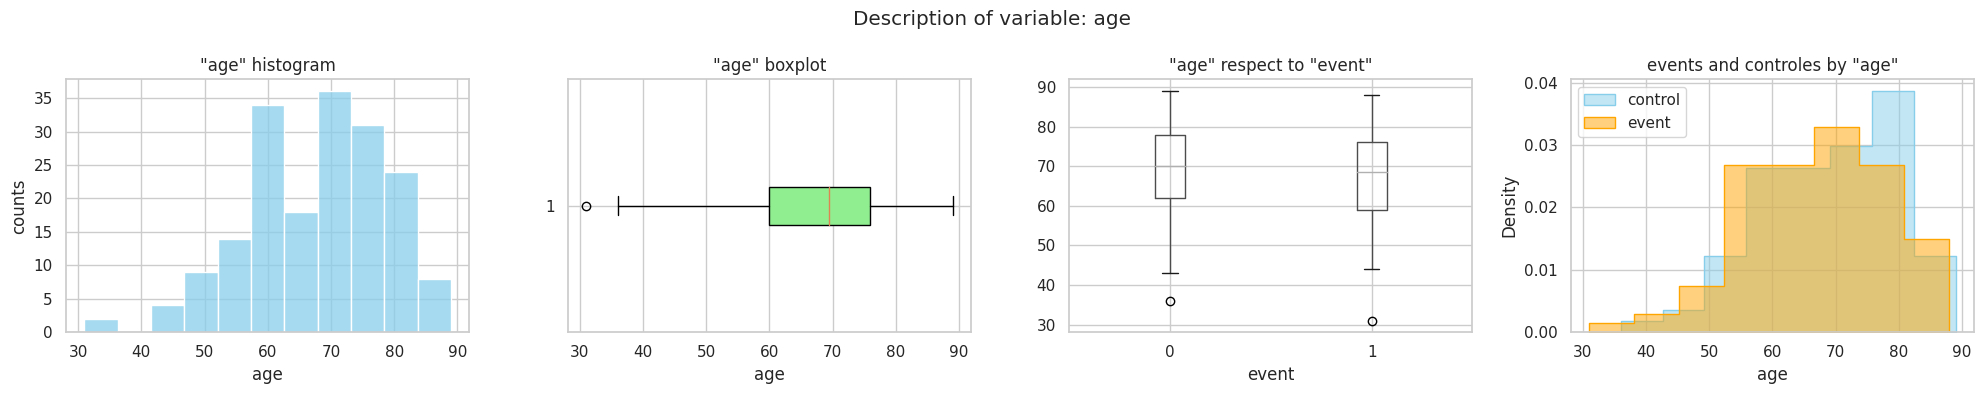

In [13]:
var_to_plot='age'
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

sns.histplot(df_clinical[var_to_plot], color='skyblue', ax=axs[0])
# axs[0].hist(df_clinical[var_to_plot], color='skyblue', alpha=0.7, density=False)
axs[0].set_title(f'"{var_to_plot}" histogram')
axs[0].set_xlabel(f'{var_to_plot}')
axs[0].set_ylabel('counts')
                        

axs[1].boxplot(df_clinical[var_to_plot], vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
axs[1].set_title(f'"{var_to_plot}" boxplot')
axs[1].set_xlabel(f'{var_to_plot}')

df_clinical.boxplot(column=var_to_plot, by='event', ax=axs[2])
axs[2].set_title(f'"{var_to_plot}" respect to "event"')


df_events = df_clinical[df_clinical['event'] == 1]
df_control = df_clinical[df_clinical['event'] == 0]

sns.histplot(df_control['age'],color='skyblue', label='control', element='step', stat='density', alpha=0.5, ax=axs[3])
sns.histplot(df_events['age'], color='orange', label='event', element='step', stat='density', alpha=0.5, ax=axs[3])
axs[3].set_title('events and controles by "age"')
axs[3].set_xlabel('age')
axs[3].set_ylabel('Density')
axs[3].legend(loc='upper left')

plt.tight_layout()

fig.suptitle(f'Description of variable: {var_to_plot}')
plt.show()

The age of the patients in the dataset is around 70 years, with an outlier in the 30s (positive case). Overall, it appears that the data are fairly well distributed in the two classes if we look at the overlaid histogram. Since age is the only numerical varaiable in the dataset an the rest are values within [0, 1], we must scale de variable 'age':

In [14]:
scaler = MinMaxScaler()
numerical = ['age']

# Aplicamos MinMaxScaler para normaliar las variables
scaler = MinMaxScaler()
df_clinical[numerical] = scaler.fit_transform(df_clinical[numerical])
df_clinical

,pid,event,rd,gender,age,dl,obe,tab,fa,hta,ic
0,216772,0,0,0,0.655172,1,0,0,1,1,0
12,471397,1,0,0,0.775862,1,0,0,1,1,0
20,234871,0,0,1,0.672414,0,1,0,1,1,0
26,27817,1,0,0,0.706897,0,0,1,0,1,0
32,529335,1,0,0,0.827586,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1453,255709,0,0,0,0.327586,0,1,0,1,1,0
1459,17188,1,0,1,0.620690,1,1,0,0,1,1
1464,464705,1,0,1,0.586207,0,0,0,1,1,0
1472,509791,1,0,0,0.517241,1,0,0,0,0,0


In [15]:
df_clinical.describe()

,pid,event,rd,gender,age,dl,obe,tab,fa,hta,ic
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,263271.383333,0.522222,0.111111,0.494444,0.635632,0.672222,0.272222,0.088889,0.677778,0.755556,0.061111
std,165904.915275,0.500899,0.315146,0.501364,0.187426,0.470713,0.446345,0.285377,0.468631,0.430956,0.240202
min,1168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,146168.250000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,206544.000000,1.000000,0.000000,0.000000,0.663793,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,383826.500000,1.000000,0.000000,1.000000,0.775862,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,617090.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Clinical variables

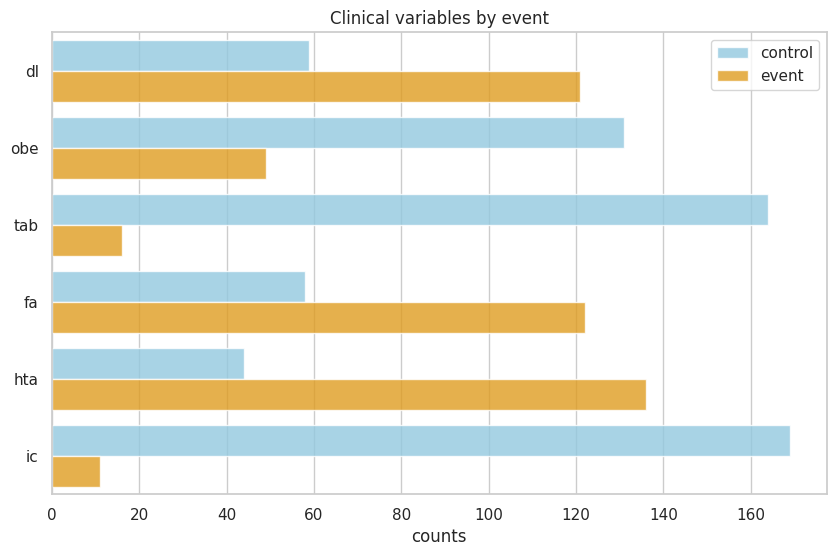

In [16]:
clinical_vars =  ['event','dl','obe','tab','fa','hta','ic']

df_clinical_vars = df_clinical[clinical_vars]

# Convertir el DataFrame a formato "largo" para facilitar el uso de seaborn
df_long = df_clinical_vars.melt(id_vars='event', value_vars=['dl', 'obe', 'tab', 'fa', 'hta', 'ic'],
                  var_name='Variable', value_name='Value')

# Configuración del gráfico
plt.figure(figsize=(10, 6))

# Crear un countplot
sns.countplot(data=df_long, y='Variable', hue='Value', palette=colors, alpha=0.8)

# Configuración de títulos y etiquetas
plt.title('Clinical variables by event')
plt.xlabel('counts')
plt.ylabel('')


# Mostrar el gráfico
plt.legend(loc='upper right', labels=['control', 'event'])
plt.show()



In general, the distribution of clinical variables by event is quite unbalanced, especially in 'ic' (Heart Failure) and 'tab'(Smoking). Variables such as hta (Hypertension), fa (Atrial Fibrillation) and dl (Dyslipidemia) seem to be important predictors of cardiac events. It should be noted that although smoking is associated with cardiovascular disease, in this dataset it does not appear to be so. It is also surprising that there are more patients with ovesity who do not present an event.

### Variables correlation

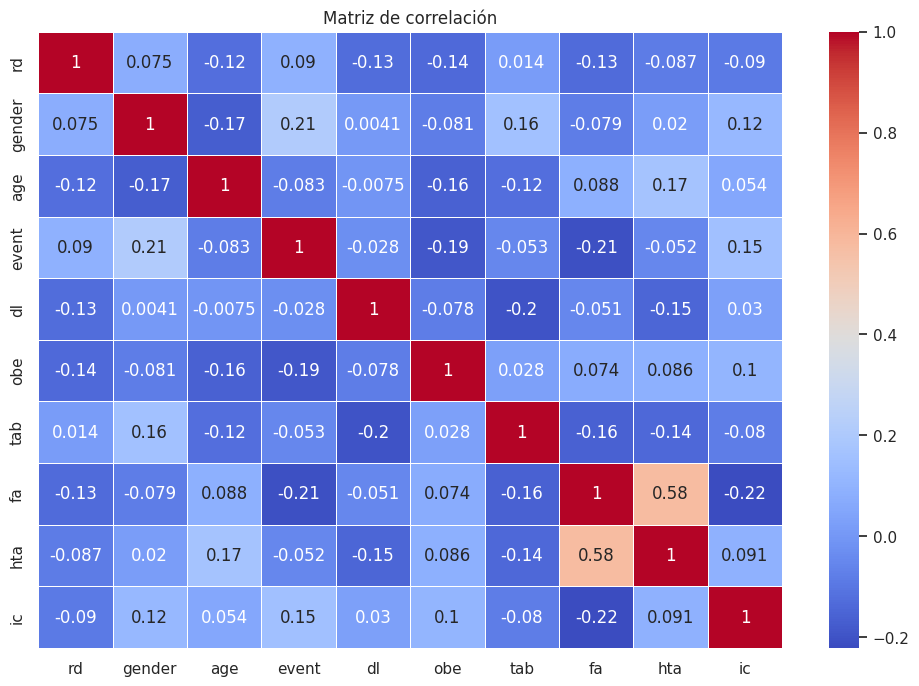

In [17]:
clinical_vars =  ['rd','gender', 'age', 'event','dl','obe','tab','fa','hta','ic']
df_clinical_vars = df_clinical[clinical_vars]

plt.figure(figsize=(12, 8))
correlation_matrix = df_clinical_vars.corr()

# Mapa de calor (Heatmap) de la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()

In [18]:
var_correlation = abs(correlation_matrix)['event'].sort_values(ascending=False)
var_correlation


event     1.000000
gender    0.211827
fa        0.207319
obe       0.189629
ic        0.151163
rd        0.090442
age       0.082557
tab       0.052978
hta       0.052335
dl        0.028170
Name: event, dtype: float64

The clinical variables most correlated from highest to lowest are: **gender > fa > obe > ic > rd > age > tab > hta > dl**

## Modeling

In [19]:
def train_and_evaluate_model(model, X, y, n_folds=5, setting='ALL'):
    accuracy_scores = []

    for i in range(n_folds):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # train model
        model.fit(X_train, y_train)
    
        # test model
        if setting == 'NO RD':
            filtered_X_test = X_test[X_test['rd'] == 0]
            filtered_y_test = y_test[filtered_X_test.index]
        elif setting == 'RD':
            filtered_X_test = X_test[X_test['rd'] == 1]
            filtered_y_test = y_test[filtered_X_test.index]
        else:
            filtered_X_test = X_test
            filtered_y_test = y_test

        y_pred = model.predict(filtered_X_test)
        split_acc = accuracy_score(filtered_y_test, y_pred)
        accuracy_scores.append(split_acc)
        print(f'[{i}] Train {X_train.shape[0]} samples, test {filtered_X_test.shape[0]} samples, setting {setting}: accuracy: {split_acc:.4f} ')

    print("----------------------------------------")
    print(f"{model.__class__.__name__} CV Accuracy in setting {setting}: {np.array(accuracy_scores).mean():.4f} ± {np.array(accuracy_scores).std():.4f}")
    print("----------------------------------------")
    
    # One sample prediction
    y_pred = model.predict(filtered_X_test)

    # metrics analysis    
    acc = accuracy_score(filtered_y_test, y_pred) 
    rec = recall_score(filtered_y_test, y_pred)
    pre = precision_score(filtered_y_test, y_pred)
    f1  = f1_score(filtered_y_test, y_pred) 
    auc = roc_auc_score(filtered_y_test, y_pred)
    print(f'Acc: {acc:.3f} | Recall: {rec:.3f} | Precision: {pre:.3f} | F1-Score: {f1:.3f} | AUC: {auc:.3f}')

    # confusion matrix
    cf_matrix = confusion_matrix(filtered_y_test, y_pred)
    plt.figure(figsize=(3,2))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix');
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])
    plt.show();

# Get features and target variables
X = df_clinical_vars.drop(columns=['event'])
y = df_clinical['event']

### Random Forest

In [20]:
RF = RandomForestClassifier(max_depth = 10, min_samples_leaf = 5, n_estimators =  50)

#### Setting: **ALL**

[0] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.6111 
[1] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.5000 
[2] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.6111 
[3] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.5833 
[4] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.5556 
[5] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.6111 
[6] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.6667 
[7] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.6667 
[8] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.7778 
[9] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.5556 
----------------------------------------
RandomForestClassifier CV Accuracy in setting ALL: 0.6139 ± 0.0729
----------------------------------------
Acc: 0.556 | Recall: 0.700 | Precision: 0.583 | F1-Score: 0.636 | AUC: 0.537


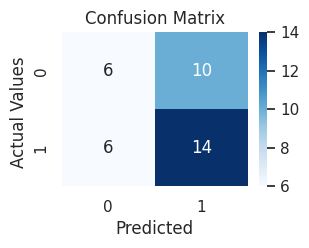

In [21]:
train_and_evaluate_model(RF, X, y, n_folds=10, setting='ALL')

#### Setting: **NO RD**

[0] Train 144 samples, test 33 samples, setting NO RD: accuracy: 0.6667 
[1] Train 144 samples, test 34 samples, setting NO RD: accuracy: 0.7059 
[2] Train 144 samples, test 30 samples, setting NO RD: accuracy: 0.6333 
[3] Train 144 samples, test 33 samples, setting NO RD: accuracy: 0.6364 
[4] Train 144 samples, test 31 samples, setting NO RD: accuracy: 0.6774 
[5] Train 144 samples, test 32 samples, setting NO RD: accuracy: 0.6875 
[6] Train 144 samples, test 30 samples, setting NO RD: accuracy: 0.5667 
[7] Train 144 samples, test 33 samples, setting NO RD: accuracy: 0.5758 
[8] Train 144 samples, test 29 samples, setting NO RD: accuracy: 0.6552 
[9] Train 144 samples, test 33 samples, setting NO RD: accuracy: 0.6970 
----------------------------------------
RandomForestClassifier CV Accuracy in setting NO RD: 0.6502 ± 0.0455
----------------------------------------
Acc: 0.697 | Recall: 0.786 | Precision: 0.611 | F1-Score: 0.688 | AUC: 0.709


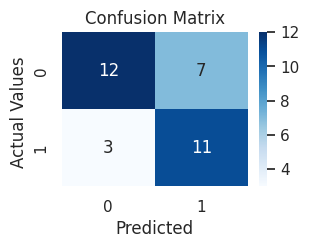

In [22]:
train_and_evaluate_model(RF, X, y, n_folds=10, setting='NO RD')

#### Setting: **RD**

[0] Train 144 samples, test 3 samples, setting RD: accuracy: 0.3333 
[1] Train 144 samples, test 4 samples, setting RD: accuracy: 0.5000 
[2] Train 144 samples, test 3 samples, setting RD: accuracy: 0.3333 
[3] Train 144 samples, test 3 samples, setting RD: accuracy: 0.6667 
[4] Train 144 samples, test 5 samples, setting RD: accuracy: 0.6000 
[5] Train 144 samples, test 7 samples, setting RD: accuracy: 0.7143 
[6] Train 144 samples, test 5 samples, setting RD: accuracy: 0.8000 
[7] Train 144 samples, test 1 samples, setting RD: accuracy: 1.0000 
[8] Train 144 samples, test 5 samples, setting RD: accuracy: 0.4000 
[9] Train 144 samples, test 3 samples, setting RD: accuracy: 0.3333 
----------------------------------------
RandomForestClassifier CV Accuracy in setting RD: 0.5681 ± 0.2169
----------------------------------------
Acc: 0.333 | Recall: 1.000 | Precision: 0.333 | F1-Score: 0.500 | AUC: 0.500


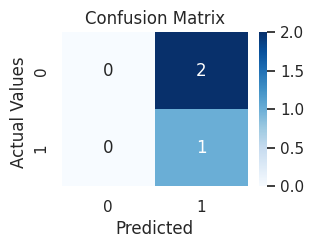

In [23]:
train_and_evaluate_model(RF, X, y, n_folds=10, setting='RD')

### Logistic Regression

In [24]:
LR = LogisticRegression(solver='liblinear', C=0.1, multi_class='auto', max_iter=1000, penalty='l2')

#### Setting: **ALL**

[0] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.5833 
[1] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.4722 
[2] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.5833 
[3] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.6389 
[4] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.6111 
[5] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.5833 
[6] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.5833 
[7] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.5833 
[8] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.4722 
[9] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.6389 
----------------------------------------
LogisticRegression CV Accuracy in setting ALL: 0.5750 ± 0.0556
----------------------------------------
Acc: 0.639 | Recall: 0.882 | Precision: 0.577 | F1-Score: 0.698 | AUC: 0.652


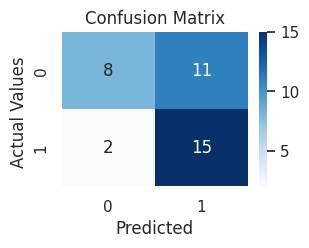

In [25]:
train_and_evaluate_model(LR, X, y, n_folds=10, setting='ALL')

#### Setting: **NO RD**

[0] Train 144 samples, test 33 samples, setting NO RD: accuracy: 0.4848 
[1] Train 144 samples, test 32 samples, setting NO RD: accuracy: 0.5000 
[2] Train 144 samples, test 34 samples, setting NO RD: accuracy: 0.6176 
[3] Train 144 samples, test 31 samples, setting NO RD: accuracy: 0.6452 
[4] Train 144 samples, test 33 samples, setting NO RD: accuracy: 0.6061 
[5] Train 144 samples, test 32 samples, setting NO RD: accuracy: 0.6875 
[6] Train 144 samples, test 31 samples, setting NO RD: accuracy: 0.6129 
[7] Train 144 samples, test 34 samples, setting NO RD: accuracy: 0.6176 
[8] Train 144 samples, test 34 samples, setting NO RD: accuracy: 0.5882 
[9] Train 144 samples, test 31 samples, setting NO RD: accuracy: 0.6774 
----------------------------------------
LogisticRegression CV Accuracy in setting NO RD: 0.6037 ± 0.0631
----------------------------------------
Acc: 0.677 | Recall: 0.562 | Precision: 0.750 | F1-Score: 0.643 | AUC: 0.681


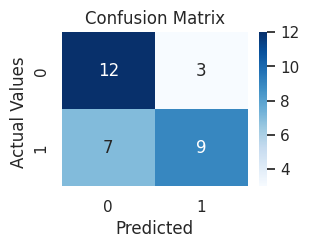

In [26]:
train_and_evaluate_model(LR, X, y, n_folds=10, setting='NO RD')

#### Setting: **RD**

[0] Train 144 samples, test 3 samples, setting RD: accuracy: 0.6667 
[1] Train 144 samples, test 5 samples, setting RD: accuracy: 0.6000 
[2] Train 144 samples, test 5 samples, setting RD: accuracy: 0.6000 
[3] Train 144 samples, test 3 samples, setting RD: accuracy: 0.3333 
[4] Train 144 samples, test 4 samples, setting RD: accuracy: 0.2500 
[5] Train 144 samples, test 6 samples, setting RD: accuracy: 0.3333 
[6] Train 144 samples, test 3 samples, setting RD: accuracy: 0.6667 
[7] Train 144 samples, test 6 samples, setting RD: accuracy: 0.8333 
[8] Train 144 samples, test 3 samples, setting RD: accuracy: 0.3333 
[9] Train 144 samples, test 4 samples, setting RD: accuracy: 0.5000 
----------------------------------------
LogisticRegression CV Accuracy in setting RD: 0.5117 ± 0.1820
----------------------------------------
Acc: 0.500 | Recall: 0.667 | Precision: 0.667 | F1-Score: 0.667 | AUC: 0.333


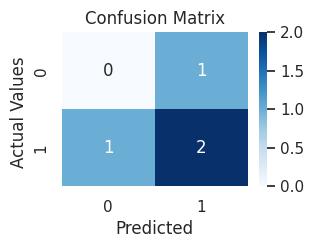

In [28]:
train_and_evaluate_model(LR, X, y, n_folds=10, setting='RD')

### Support Vector Machine

In [29]:
SVEC = SVC(kernel='rbf', C=0.1, gamma='scale')

#### Setting: **ALL**

[0] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.4722 
[1] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.4444 
[2] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.6389 
[3] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.5000 
[4] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.3056 
[5] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.3611 
[6] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.4722 
[7] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.6667 
[8] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.5278 
[9] Train 144 samples, test 36 samples, setting ALL: accuracy: 0.6389 
----------------------------------------
SVC CV Accuracy in setting ALL: 0.5028 ± 0.1135
----------------------------------------
Acc: 0.639 | Recall: 0.714 | Precision: 0.682 | F1-Score: 0.698 | AUC: 0.624


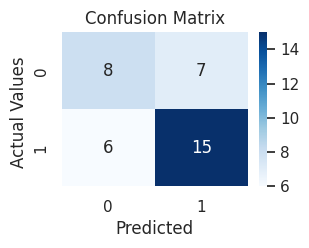

In [30]:
train_and_evaluate_model(SVEC, X, y, n_folds=10, setting='ALL')

#### Setting: **NO RD**

[0] Train 144 samples, test 33 samples, setting NO RD: accuracy: 0.4848 
[1] Train 144 samples, test 30 samples, setting NO RD: accuracy: 0.4000 
[2] Train 144 samples, test 33 samples, setting NO RD: accuracy: 0.4242 
[3] Train 144 samples, test 31 samples, setting NO RD: accuracy: 0.3548 
[4] Train 144 samples, test 32 samples, setting NO RD: accuracy: 0.5312 
[5] Train 144 samples, test 30 samples, setting NO RD: accuracy: 0.6000 
[6] Train 144 samples, test 34 samples, setting NO RD: accuracy: 0.4412 
[7] Train 144 samples, test 32 samples, setting NO RD: accuracy: 0.4688 
[8] Train 144 samples, test 32 samples, setting NO RD: accuracy: 0.4688 
[9] Train 144 samples, test 35 samples, setting NO RD: accuracy: 0.5429 
----------------------------------------
SVC CV Accuracy in setting NO RD: 0.4717 ± 0.0687
----------------------------------------
Acc: 0.543 | Recall: 0.944 | Precision: 0.531 | F1-Score: 0.680 | AUC: 0.531


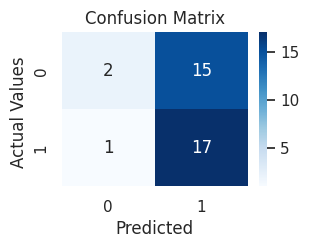

In [31]:
train_and_evaluate_model(SVEC, X, y, n_folds=10, setting='NO RD')

#### Setting: **RD**

[0] Train 144 samples, test 2 samples, setting RD: accuracy: 0.5000 
[1] Train 144 samples, test 5 samples, setting RD: accuracy: 0.6000 
[2] Train 144 samples, test 7 samples, setting RD: accuracy: 0.4286 
[3] Train 144 samples, test 4 samples, setting RD: accuracy: 0.2500 
[4] Train 144 samples, test 6 samples, setting RD: accuracy: 0.5000 
[5] Train 144 samples, test 3 samples, setting RD: accuracy: 0.3333 
[6] Train 144 samples, test 4 samples, setting RD: accuracy: 0.7500 
[7] Train 144 samples, test 5 samples, setting RD: accuracy: 0.4000 
[8] Train 144 samples, test 4 samples, setting RD: accuracy: 0.5000 
[9] Train 144 samples, test 4 samples, setting RD: accuracy: 0.7500 
----------------------------------------
SVC CV Accuracy in setting RD: 0.5012 ± 0.1550
----------------------------------------
Acc: 0.750 | Recall: 1.000 | Precision: 0.750 | F1-Score: 0.857 | AUC: 0.500


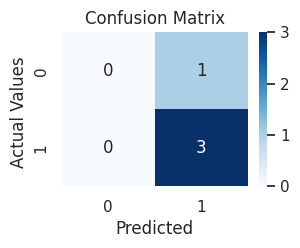

In [32]:
train_and_evaluate_model(SVEC, X, y, n_folds=10, setting='RD')

## Evaluating a Linear Regression model 

C-index: 0.7031746031746032


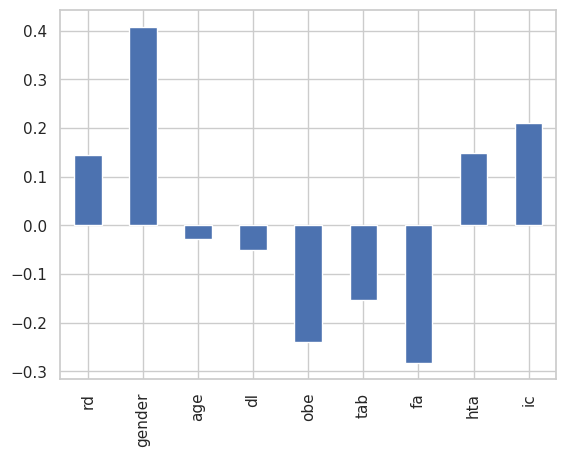

In [55]:
LR = LogisticRegression(solver='liblinear', C=0.1, multi_class='auto', max_iter=1000, penalty='l2')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

LR.fit(X_train, y_train)

y_pred_proba = LR.predict_proba(X_test)[:, 1]
c_index = concordance_index(y_test, y_pred_proba)

print(f"C-index: {c_index}")

coeffs = pd.DataFrame(data = LR.coef_, columns = X_train.columns)
coeffs.T.plot.bar(legend=None);

It seems that rd, age, gta abd ic have a positive coefficient. This means that a higher value in these features leads to a higher prediction probability for the event.

     rd  gender       age  dl  obe  tab  fa  hta  ic  event_risk
202   0       0  0.517241   1    0    0   0    0   0    0.718088
940   1       1  0.517241   0    0    0   0    0   0    0.697220
621   0       1  0.517241   0    0    0   1    1   0    0.695955
326   0       0  0.086207   1    0    0   0    0   0    0.684219
368   0       1  0.862069   1    0    0   0    0   0    0.683715
Riskier patient: 202


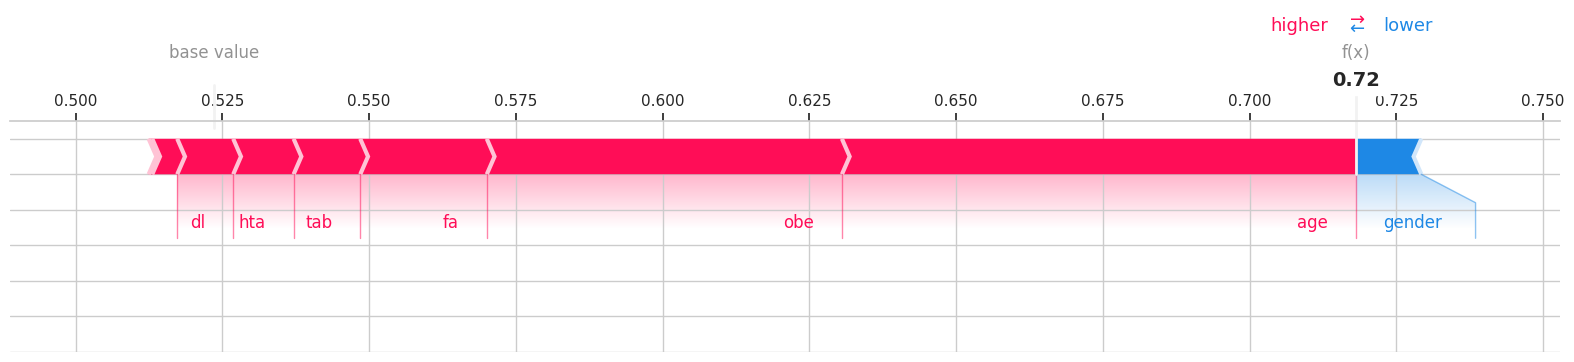

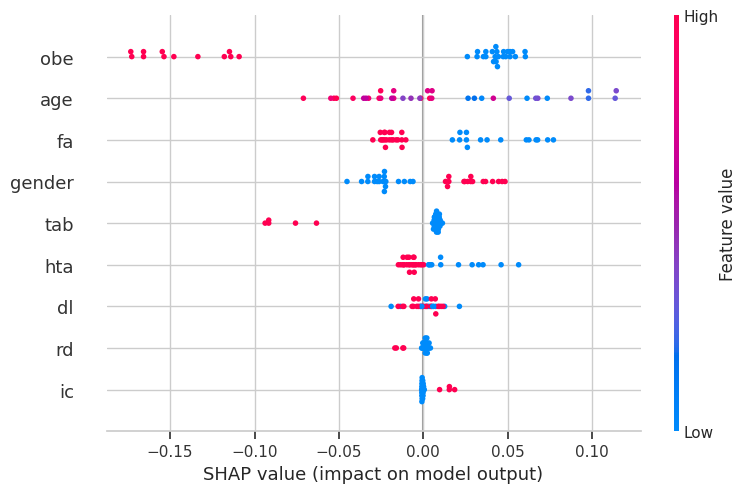

In [85]:
RF = RandomForestClassifier(max_depth = 10, min_samples_leaf = 5, n_estimators =  50)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

RF.fit(X_train, y_train)

X_test_risk = X_test.copy(deep=True)
X_test_risk.loc[:, 'event_risk'] = RF.predict_proba(X_test_risk)[:, 1]
X_test_risk = X_test_risk.sort_values(by='event_risk', ascending=False)
print(X_test_risk.head())

explainer = shap.TreeExplainer(RF)
shap_values = explainer.shap_values(X_test)

# 0 = control, 1 = event
class_to_monitor = 1 

riskier_index=X_test_risk.index[0]
print(f'Riskier patient: {riskier_index}')
riskier_position = X_test.index.get_loc(riskier_index)
shap.plots.force(explainer.expected_value[class_to_monitor], shap_values[riskier_position, :, class_to_monitor], feature_names=X_test.columns, matplotlib = True)

shap.summary_plot(shap_values[:, :, class_to_monitor], X_test)

How to read this chart:
- The red sections on the left are features which push the model towards the final prediction in the positive direction (i.e. a higher Age increases the predicted risk).
- The blue sections on the right are features that push the model towards the final prediction in the negative direction (if an increase in a feature leads to a lower risk, it will be shown in blue).